# Deep dream

Classic deep dream images are based on maximising the total activations for a given layer.

![](dream.png)

In [1]:
import sumie
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import skimage

%matplotlib inline

In [6]:
model = torchvision.models.densenet121(pretrained=True).eval()
sumie.utils.remove_inplace(model)

device = 'cuda' if torch.cuda.is_available else 'cpu'
model.to(device);

### Load a base image

Usually deep dream images are made by starting with a base image and then optimising that for a given response from the network, sumie has some helpers functions to load images into the correct size and scale tensors

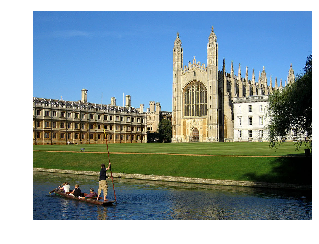

In [7]:
url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/b/b4/KingsCollegeChapelWest.jpg/1024px-KingsCollegeChapelWest.jpg'
imsize = (645, 861)
base_image = sumie.io.load_url(url, size=imsize)
sumie.vis.show(base_image)

### Dream deeply

Create an image and specify to use the above image as the initial value. Use the default frequency space normalisation and a bunch of transforms.

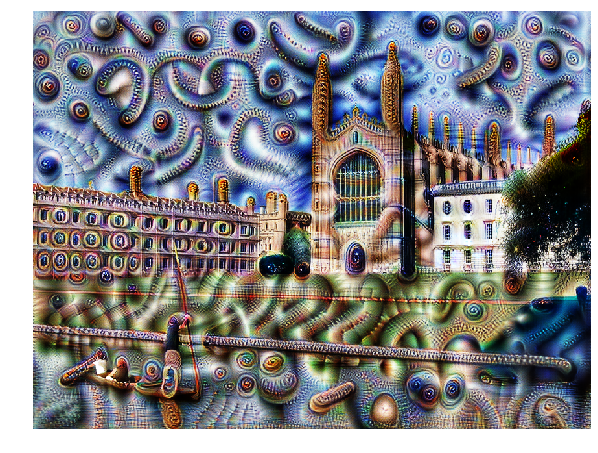

In [8]:
im = sumie.Image(imsize, init=base_image, 
                             transforms = [
                                 sumie.transforms.PositionJitter(16),
                                 sumie.transforms.ScaleJitter(1.01),
                                 sumie.transforms.Interpolate(0.5),
                                 sumie.transforms.PositionJitter(8),
                                 sumie.transforms.Normalise(),
                             ])
im.to(device)
# This layer produces lower level shapes
layer = list(model.modules())[136]
dream = sumie.objectives.DeepDream(layer)

opt = sumie.Optimiser(im, model, dream)
opt.run(iterations=100, lr=0.025, progress=True)
sumie.vis.show(im.get_image(), figsize = (10, 10))

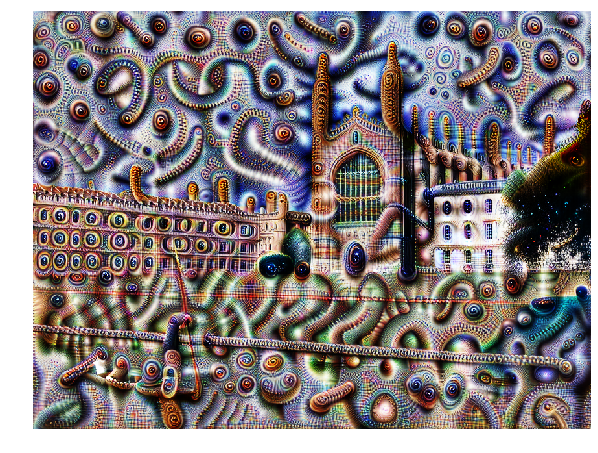

In [9]:
opt.image.transforms[2].factor = 1
opt.run(iterations=25, progress=True)
sumie.vis.show(im.get_image(), figsize = (10, 10))

In [10]:
sumie.io.save(im.get_image(), 'dream.png')

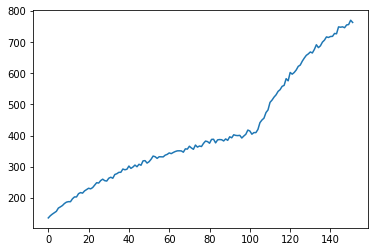

In [7]:
plt.plot([x.item() for x in opt.history])